In [1]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Input
from tensorflow.keras.initializers import GlorotUniform
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from sklearn.metrics import r2_score
from keras.callbacks import Callback
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))



TensorFlow version used: 2.15.0


In [2]:
# Final time
T = tf.constant(1., dtype=DTYPE)

# Spatial dimensions
dim2 = 50
num_pairs = 25
# Final time
T = tf.constant(1., dtype=DTYPE)

# Constants for the ranges of stock prices and volatilities
stock_price_low, stock_price_high = 90, 110
volatility_low, volatility_high = 0.02, 0.2

Alpha, Beta, Kappa, Theta, rho = 0.05,  0.2, 0.6, 0.04, -0.8
# Define the payoff function phi
def phi(x):
    # We're extracting all the stock prices, which are every second element starting from index 0 (hence the slicing ::2).
    stock_prices1 = x[:, ::2]  # This selects all stock prices from the interleaved array
    payoff = tf.exp(-Alpha * T) * tf.maximum(110.0 - tf.reduce_mean(stock_prices1, axis=1), 0.0)
    return payoff  # The shape of 'payoff' here should be [batch_size]



In [3]:
def simulate_paths(num_samples, N=100, num_time_steps=None):
    # If num_time_steps isn't provided, default to N
    if num_time_steps is None:
        num_time_steps = N

    dt = T / tf.cast(num_time_steps, DTYPE)  # time interval

    # Initialize stock_prices and volatilities randomly
    current_stock_prices = tf.random.uniform((num_samples, num_pairs), minval=stock_price_low, maxval=stock_price_high, dtype=DTYPE)
    current_volatilities = tf.random.uniform((num_samples, num_pairs), minval=volatility_low, maxval=volatility_high, dtype=DTYPE)

    # Iterate over time steps
    for step in range(num_time_steps):
        # Generate random normal values for the Wiener process
        dw_shape = (num_samples, num_pairs)
        dw = tf.random.normal(shape=dw_shape, stddev=np.sqrt(dt), dtype=DTYPE)

        # Calculations for volatility
        A_1 = (rho * dw + np.sqrt(1. - rho ** 2) * dw) * Beta / 2
        A_2 = tf.maximum(Beta / 2 * tf.sqrt(dt), tf.sqrt(current_volatilities))
        A_3 = A_1 + A_2
        A_4 = (tf.maximum(Beta / 2 * tf.sqrt(dt), A_3)) ** 2
        volatility_drift = (Kappa * Theta - (Beta ** 2) / 4 - Kappa * current_volatilities) * dt
        new_volatilities = tf.maximum(A_4 + volatility_drift, 0)

        # Calculations for stock prices
        stock_drift = (Alpha - current_volatilities / 2) * dt + dw * tf.sqrt(current_volatilities)
        new_stock_prices = current_stock_prices * tf.exp(stock_drift)

        # Update the current stock prices and volatilities for the next iteration
        current_stock_prices = new_stock_prices
        current_volatilities = new_volatilities


    # After the loop, 'current_stock_prices' and 'current_volatilities' hold the last iteration values
    # To interleave stock prices and volatilities, we first expand their dimensions
    expanded_stocks = tf.expand_dims(current_stock_prices, -1)  # [num_samples, num_pairs, 1]
    expanded_vols = tf.expand_dims(current_volatilities, -1)    # [num_samples, num_pairs, 1]

    # We then concatenate them along the last dimension
    interleaved = tf.concat([expanded_stocks, expanded_vols], axis=2)  # [num_samples, num_pairs, 2]

    # Finally, we reshape the tensor to flatten the last dimension
    final_shape = (num_samples, num_pairs * 2)
    result = tf.reshape(interleaved, final_shape)  # [num_samples, num_pairs * 2], like [price1, vol1, price2, vol2, ...]

    return result

In [21]:
# Constants
NUM_PATHS = 600  # Number of paths to simulate
M = 200000  # Total number of simulations
VECTOR_SIZE = 100  # Number of simulations to vectorize in each loop iteration

# Number of iterations needed with vectorization
num_iterations = M // VECTOR_SIZE

# Initialize an array to store the mean payoffs
mean_payoffs = np.zeros(M)

# Process in larger batches
for i in range(num_iterations):
    # Simulate multiple paths in one go
    simulated_paths = simulate_paths(NUM_PATHS * VECTOR_SIZE)

    # Reshape to treat each set of NUM_PATHS as a separate batch
    # This step depends on the structure of your simulate_paths output
    reshaped_paths = np.reshape(simulated_paths, (VECTOR_SIZE, NUM_PATHS, -1))

    # Calculate phi for each batch of paths and compute the mean
    for j in range(VECTOR_SIZE):
        payoffs = phi(reshaped_paths[j, :, :])
        mean_payoff = np.mean(payoffs)
        mean_payoffs[i * VECTOR_SIZE + j] = mean_payoff

# Handle any remaining simulations
remaining = M % VECTOR_SIZE
if remaining > 0:
    simulated_paths = simulate_paths(NUM_PATHS * remaining)
    reshaped_paths = np.reshape(simulated_paths, (remaining, NUM_PATHS, -1))
    for j in range(remaining):
        payoffs = phi(reshaped_paths[j, :, :])
        mean_payoff = np.mean(payoffs)
        mean_payoffs[num_iterations * VECTOR_SIZE + j] = mean_payoff

# 'mean_payoffs' now contains the mean payoffs for all M iterations


In [22]:
mean_payoffs.shape

(200000,)

In [23]:
# Reshape array1 to match the shape of array2
AZZ= mean_payoffs.reshape(-1, 1)  # Shape (2000, 1)

In [24]:
num_batches = 200000
#generate input data for our DNN
S_0 = tf.random.uniform((num_batches, num_pairs), minval=stock_price_low, maxval=stock_price_high, dtype=DTYPE)
V_0 = tf.random.uniform((num_batches, num_pairs), minval=volatility_low, maxval=volatility_high, dtype=DTYPE)

S_0_reshaped = tf.reshape(S_0, [num_batches, num_pairs, 1])
V_0_reshaped = tf.reshape(V_0, [num_batches, num_pairs, 1])

# Interleave 'S_0' and 'V_0' along the last dimension
combined_data = tf.concat([S_0_reshaped, V_0_reshaped], axis=-1)  # Shape: [2, num_pairs, 2]

# Reshape the combined data to create a single row
X_train2 = tf.reshape(combined_data, [num_batches, -1])



In [25]:
Y_train = np.array(mean_payoffs)
df = pd.DataFrame(X_train2)
df['Y_train'] = Y_train
# Initial split (80% training, 20% temporary test set)
X_train2, X_temp, y_train2, y_temp = train_test_split(df.drop(columns=['Y_train']), df['Y_train'], test_size=0.2)

# Now, split the temporary test set into validation and test sets.
# Since we want the validation and final test sets to come out of the 20% data, we split X_temp and y_temp in half.
# This means the validation and test sets will be 10% of the original data each.
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5)

In [26]:
class PredictionHistory(Callback):
    def on_train_begin(self, logs={}):
        self.predictions = []
        self.losses = []
        self.val_losses = []
        self.epoch_run_times = []
        self.cumulative_run_time = 0

    def on_epoch_begin(self, epoch, logs={}):
        # Start the timer for the epoch
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        # Calculate and save the run time for the epoch
        run_time = time.time() - self.start_time
        self.epoch_run_times.append(run_time)
        self.cumulative_run_time += run_time

        # Save losses
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        # Save the last prediction for the current epoch
        current_predictions = self.model.predict(X_val2)
        last_prediction = current_predictions[-1] if len(current_predictions) > 0 else 0
        self.predictions.append(last_prediction)

# Initialize the callback
prediction_history = PredictionHistory()

In [27]:
def init_model(dim, activation='tanh',
               num_hidden_neurons=300,
               num_hidden_layers=6,
               initializer=GlorotUniform()):
    model = Sequential()
    model.add(Input(shape=(dim,)))
    model.add(BatchNormalization(epsilon=1e-6))

    # Create a fixed number of hidden layers
    for _ in range(num_hidden_layers):
        model.add(Dense(num_hidden_neurons,
                        activation=None,
                        use_bias=False,
                        kernel_initializer=initializer))
        model.add(BatchNormalization(epsilon=1e-6))
        model.add(Activation(activation))

    model.add(Dense(1,
                    activation=None,
                    use_bias=False,
                    kernel_initializer=initializer))
    model.add(BatchNormalization(epsilon=1e-6))
    return model

In [28]:
# Define the model
model = init_model(dim=dim2)

# Learning rate schedule and optimizer
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([500, 1000], [1e-4, 1e-5, 1e-6])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

c:\Users\yjerm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Bat  (None, 50)                200       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 300)               15000     
                                                                 
 batch_normalization_9 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 300)               0         
                                                                 
 dense_8 (Dense)             (None, 300)               90000     
                                                                 
 batch_normalization_10 (Ba  (None, 300)              

In [29]:
# Train the model
start_time = time.time()
history2 = model.fit(X_train2, y_train2,batch_size = 256, epochs=2000, validation_data=(X_val2, y_val2), callbacks=[prediction_history]) 
end_time = time.time()
total_time = end_time - start_time

# Print the total time
print(f"Total time for model fitting: {total_time/3600:.3f} hours")

#The following code is for saving data traning in csv file.
# Convert the training history to a DataFrame
#history2_df = pd.DataFrame(history.history)

# Add a column for the time taken for training
#history2_df['training_time'] = total_time

# Save the history to a CSV file
#history2_df.to_csv('training_history2.csv', index=False)

Epoch 1/2000

625/625 [==============================] - 12s 15ms/step - loss: 11.7918 - val_loss: 3.9114
Epoch 2/2000
625/625 [==============================] - 9s 14ms/step - loss: 3.4807 - val_loss: 3.2828
Epoch 3/2000
625/625 [==============================] - 9s 14ms/step - loss: 3.2503 - val_loss: 3.1996
Epoch 4/2000
625/625 [==============================] - 9s 14ms/step - loss: 3.1709 - val_loss: 3.1318
Epoch 5/2000
625/625 [==============================] - 9s 14ms/step - loss: 3.0936 - val_loss: 3.0474
Epoch 6/2000
625/625 [==============================] - 9s 14ms/step - loss: 3.0181 - val_loss: 2.9737
Epoch 7/2000
625/625 [==============================] - 9s 14ms/step - loss: 2.9446 - val_loss: 2.9037
Epoch 8/2000
625/625 [==============================] - 9s 14ms/step - loss: 2.8729 - val_loss: 2.8344
Epoch 9/2000
625/625 [==============================] - 9s 14ms/step - loss: 2.8028 - val_loss: 2.7620
Epoch 10/2000
625/625 [==============================] - 9s 14ms/step 

In [30]:
results_df = pd.DataFrame({
    'Epoch': range(1, len(prediction_history.losses) + 1),
    'Training Loss': prediction_history.losses,
    'Validation Loss': prediction_history.val_losses,
    'Last Prediction': prediction_history.predictions,
    'Epoch Run Time (s)': prediction_history.epoch_run_times,
    'Cumulative Run Time (s)': [sum(prediction_history.epoch_run_times[:i+1]) for i in range(len(prediction_history.epoch_run_times))]
})

# Save the DataFrame to a CSV file
results_df.to_csv('model_performance_grddrdiz.csv', index=False)

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and obtained predictions for both validation and test data
y_pred_val2 = model.predict(X_val2)  # Predictions for validation data
y_pred_test2 = model.predict(X_test2)  # Predictions for test data
y_pred_train2 = model.predict(X_train2)  # Predictions for training data

# Calculate MAE for all three datasets
mae_val2 = mean_absolute_error(y_val2, y_pred_val2)
mae_test2 = mean_absolute_error(y_test2, y_pred_test2)
mae_train2 = mean_absolute_error(y_train2, y_pred_train2)

# Calculate MSE for all three datasets
mse_val2 = mean_squared_error(y_val2, y_pred_val2)
mse_test2 = mean_squared_error(y_test2, y_pred_test2)
mse_train2 = mean_squared_error(y_train2, y_pred_train2)

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Data: {mae_val2:.4f}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae_test2:.4f}")
print(f"Mean Absolute Error (MAE) on Training Data: {mae_train2:.4f}")

print(f"Mean Squared Error (MSE) on Validation Data: {mse_val2:.4f}")
print(f"Mean Squared Error (MSE) on Test Data: {mse_test2:.4f}")
print(f"Mean Squared Error (MSE) on Training Data: {mse_train2:.4f}")


5000/5000 [==============================] - 10s 2ms/step
Mean Absolute Error (MAE) on Validation Data: 0.1598
Mean Absolute Error (MAE) on Test Data: 0.1566
Mean Absolute Error (MAE) on Training Data: 0.1584
Mean Squared Error (MSE) on Validation Data: 0.0400
Mean Squared Error (MSE) on Test Data: 0.0386
Mean Squared Error (MSE) on Training Data: 0.0394


In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

NameError: name 'cf' is not defined

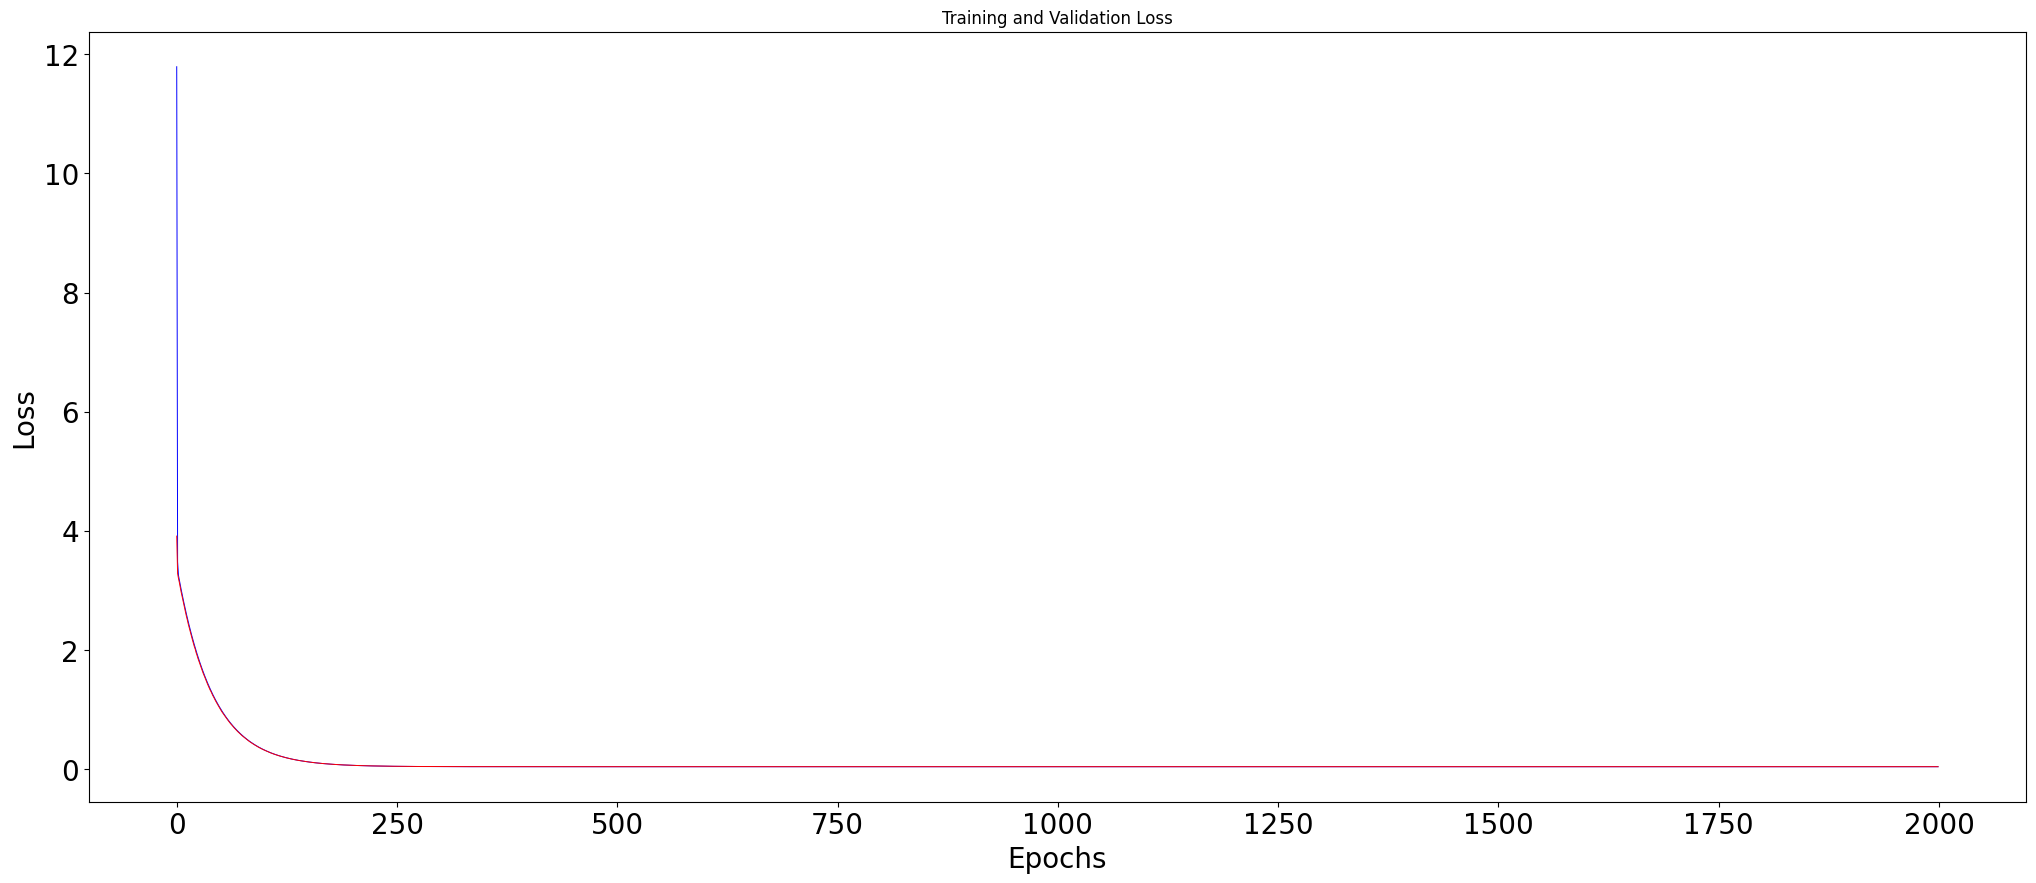

In [44]:
performance = pd.read_csv("model_performance_grddrdiz.csv")
# Create a subplot grid with two subplots side by side
plt.figure(figsize=(25, 10))

# Plot the blue line for "Approximation" and the horizontal line for "Exact Solution" on the first subplot
plt.plot(performance['Training Loss'], color = 'b',label="Training_Loss", linewidth=0.7)
plt.plot(performance['Validation Loss'], color = 'r',label="Validation_Loss", linewidth=0.7)

plt.xlabel('Epochs',fontsize="20")
plt.ylabel('Loss',fontsize="20")
plt.title('Training and Validation Loss')
plt.xticks(size = 20)
plt.yticks(size = 20)


# Customize the plot style
# Plot using Cufflinks
cf.go_offline()
combined.iplot(# Plot using Cufflinks
cf.go_offline()
combined.iplot(title='Adjusted Close Prices: Apple vs Microsoft'))
# plt.style.use("seaborn")
plt.ylim(0.035,0.1)
# plt.savefig("training_loss_plot_multi assets.jpg", format="jpeg", dpi = 500)
plt.legend(fontsize="20")
# Show the combined plot
plt.show()